In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from msc_filtering import MyKalmanFilterZeroOrder, MyKalmanFilterHigherOrder, MyKalmanFilterEKF, run_filter

## Some theory

#### State space processes

The discrete linear time invariant (LTI) state-space process model defines the evolution of the state from time k−1 to time k  as:

$x_k=Fx_{k−1}+Bu_{k}+w_{k}$

$x$: state vector (n x 1)<br> 
$F$: state transition matrix (n x n) - $F = \frac{\partial f(x)}{\partial x}$ <br> 
$u$: control vector <br> 
$B$: control-input matrix <br> 
$w$: process noise vector (n x 1) $w \sim N(0,Q)$ -> $Q$ (n x n) -> To account for any unmodelled behavior 

The measurement/observation model describes the relationship between the state and the measurement at the current time step $k$

$z_k=Hx_{k}+{\upsilon}_k$

$z$: measurement vector. This is the measured value (m x 1) <br> 
$H$: measurement matrix (m x n)<br> 
$\upsilon$: measurement noise vector (m x 1) $\upsilon \sim N(0,R)$ -> $R$ (m x m)

$F$ is a discretised process which can be found from a continous linear first order state space model using the infinite sum:

From: <br>
$\dot{x} = A \cdot x $

One can find:<br>
$F_t = e^{{\Delta}tA} = I + \sum_{i=1}^{\infty}\frac{{\Delta}t^iA^i}{i!} $ <br>
- Where $I$ is the identity matrix
- $x_1 = x_0 e^{A{\Delta}t}$ is the solution to a first order differential equation
- Using Taylor series expansion:
$e^x= 1 + \sum_{i=1}^{\infty}\frac{x^i}{i!} $ -> describes/approximates the local region around a function with a differentiable polynomial

If you take a differential equation and discretize it in order to solve it numerically you will end up with a difference equation (difference between two consecutive values - can use to create a corresponding recursive equation) 

Note the similarities to the Newtonian equations: <br>
Constant velocity model: <br>
$x_t = x_{t-1} + v\Delta t$ <br>
$v_t = v_{t-1}$ <br>
Constant accelleration model: <br>
$x_t = \frac{1}{2}at^2+v_0t+x_0$ <br>

#### Standard kalman filter

Kalman filter is a a minimum mean-squared error (MMSE) state estimator for iscrete-time dynamic systems e characterized by a linear state space model with Gaussian noise.

Initialise: <br>
$x_{0|0}$ -> The "previous value of x" initialised to the starting value <br>
$P_{0|0}$ -> The error covariance (Uncertainty of the estimate). Variance is $\sigma^2$ <br>
When a relatively large error covaraiance is used for initialisation, the system tends towards using the first measurement as the new state (rather than the initial value of x) and converges over time. 

Prediction from action model: <br>
$x_{t|t-1}=Fx_{t-1|t-1}+Bu_{t|t}$ -> The expected value of x (intermediate). No noise added since white - which means that the mean of the noise will be 0 <br>
$P_{t|t-1}=FP_{t-1|t−1}F^T+Q$ -> The uncertainty of the estimate growth by dynamics and noise. <br>
Where $x_{t-1|t-1}$ is known as the prior estimate

Compute optimal Kalman gain: <br>
$K = P_{t|t-1}H^T(HP_{t|t-1}H^T+R)^{-1}$ -> (n x m) Trade off between prediction and measurements. Relatively large measurement noise leads to smaller gain. 

Correction from sensor: <br>
$x_{t|t}=x_{t|t−1}+K(z_t-Hx_{t|t-1})$ -> Lower gain emphesizes measurements less. The measurement residual is also known as the "innovation" term, which is the difference between the actual measurement and the expected measurement <br>
$P_{t|t}=(I-KH)P_{t|t-1}$ -> The uncertainty estimate shrinks based on observations. This is the variance of the optimium combined estimate. This gives the theoretical performance assuming all inputs and assumptions are accurate - however does not reflect the actual performance

Order refers to the number of derivatives needed to model the system accurately. When the Kalman filter is of higher order than your physical process it also has an infinite number of solutions that is can converge to (overfitting) which can lead to diverging behavior therefore the filter order should correspond to the problem. Adaptive filters adapt to changing order in an objects behavior.

There is nothing stopping us from using higher orders - we can model jerk, jounce, snap, and so on. We don't do that normally because adding terms beyond the dynamics of the real system actually degrades the solution

#### Noise model

Using Piecewise White Noise Model (Constant noise on each timestep applied to highest order term): <br>
$f(x)=Fx+Γw$ -> $Γ$ is the noise gain which is the transmission ratio of the noise mangitude through the system (e.g. noise applied to velocity transmits to $\frac{1}{2}\Delta t^2$ for position.)

The process noise covariance is then: $Q = Γ\sigma ^2Γ^T$


## Try Kalman filtering

####  Constant process with zero order filter (constant model)

Ball with constant position at L=1m

In [2]:
measure_list_1 = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]

Define kalman filter params

In [3]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - Init high since unknown
Q = 0.0001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [4]:
zeroFilter_const = MyKalmanFilterZeroOrder(x0, p0, R, Q)
df_level = run_filter(zeroFilter_const, measure_list_1)
df_level

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.000100,0.999900,0.899910,0.099990
1,0.899910,0.100090,0.500225,0.849933,0.050022
2,0.849933,0.050122,0.333877,0.933424,0.033388
3,0.933424,0.033488,0.250867,0.950126,0.025087
4,0.950126,0.025187,0.201193,0.950101,0.020119
5,0.950101,0.020219,0.168187,0.966902,0.016819
6,0.966902,0.016919,0.144705,1.000633,0.014470
7,1.000633,0.014570,0.127175,0.987835,0.012717
8,0.987835,0.012817,0.113613,0.972175,0.011361
9,0.972175,0.011461,0.102827,0.990460,0.010283


Check results

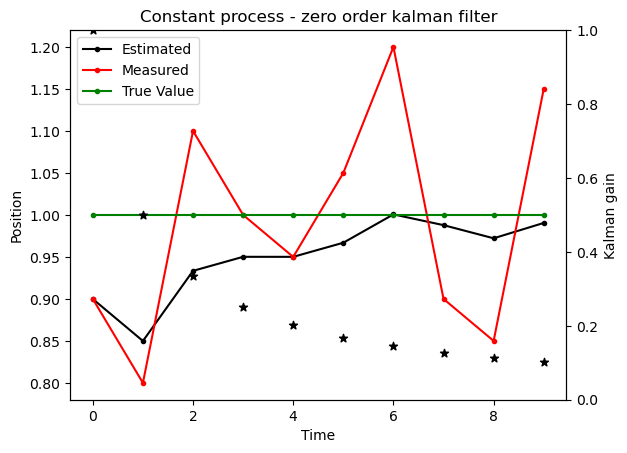

In [5]:
plt.plot(df_level.index, df_level['xt_curr'] ,marker=".",color="black")
plt.plot(df_level.index, measure_list_1 ,marker=".",color="red")
plt.plot(df_level.index, np.ones(len(df_level.index)) ,marker=".",color="g")
plt.title("Constant process - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_level.index, df_level['k_gain'],marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

#### Constant increasing process with zero order filter

Ball with constant motion 0.1 per step

In [6]:
rising_zero_gt = np.arange(1,7)*0.1
rising_zero_gt

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [7]:
measure_list_2 = [0.11, 0.29, 0.32, 0.5, 0.58, 0.54]

Define kalman filter params

In [8]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - High since unknown
Q = 0.0001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [9]:
zeroFilter_rising = MyKalmanFilterZeroOrder(x0, p0, R, Q)
df_rising_zero = run_filter(zeroFilter_rising, measure_list_2)
df_rising_zero

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.000100,0.999900,0.109989,0.099990
1,0.109989,0.100090,0.500225,0.200035,0.050022
2,0.200035,0.050122,0.333877,0.240089,0.033388
3,0.240089,0.033488,0.250867,0.305292,0.025087
4,0.305292,0.025187,0.201193,0.360561,0.020119
5,0.360561,0.020219,0.168187,0.390741,0.016819


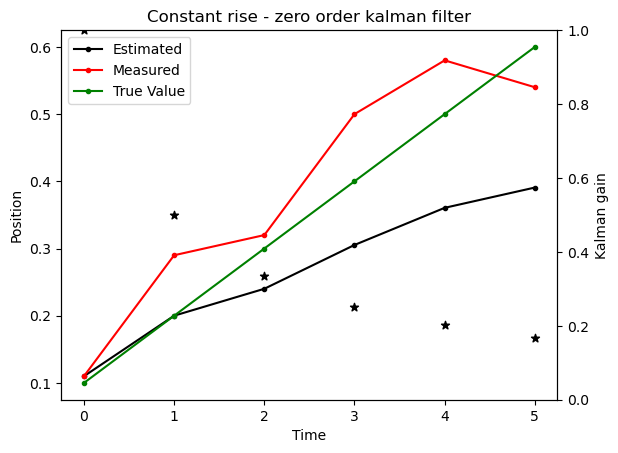

In [10]:
plt.plot(df_rising_zero.index, df_rising_zero['xt_curr'] ,marker=".",color="black")
plt.plot(df_rising_zero.index, measure_list_2 ,marker=".",color="red")
plt.plot(df_rising_zero.index, rising_zero_gt ,marker=".",color="g")
plt.title("Constant rise - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_rising_zero.index, df_rising_zero['k_gain'],marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

Because the filter model assumes that there will be no change (model mismatch), the filter lags behind. There are no enough terms in the model to allow it to "catch up". Increasing the sampling rate can help.

The error greatly increases as the Kalman gain which places a greater emphesis on the weighting of the model, however, the model is not in agreement with the process. This difference can be attempted to be compensated by including the difference as process noise, however, since the difference it is not gaussian the "optimum gain" is not actually the optimum. In this case the over confidence of the Kalman gain is to the detriment of the performance.  

#### Constant increasing process with first order filter (aka constant velocity model)

Using a sampling rate of $\Delta t= 1$

In [11]:
delta_t = 1

In [12]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.0001
# Piecewiese white noise model
# This noise model assumes white noise on the lambda state (constant over a time cycle)
Q = q*np.array([[(delta_t**4)/4, (delta_t**3)/2],
                [(delta_t**3)/2,   (delta_t**2)]])
H = np.array([1, 0])

In [13]:
firstFilter_rising = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_rising_first = run_filter(firstFilter_rising,measure_list_2)
df_rising_first

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0]","[[2000.000025, 1000.00005], [1000.00005, 1000....","[0.9998500224985, 0.4999250299964377]","[0.109983502474835, 0.05499175329960814]","[[0.2999550067495006, 0.1499775089989066], [0...."
1,"[0.16497525577444314, 0.05499175329960814]","[[0.7499125412450955, 0.3000050254966883], [0....","[0.7142619140026379, 0.2857428725833783]","[0.2542756688826796, 0.09071668285862089]","[[0.21427857420079144, 0.08572286177501351], [..."
2,"[0.3449923517413005, 0.09071668285862089]","[[0.42863216006613214, 0.12865572409032716], [...","[0.5882696147082345, 0.176571569499005]","[0.330290110611793, 0.08630374408618827]","[[0.1764808844124703, 0.05297147084970148], [0..."
3,"[0.41659385469798127, 0.08630374408618827]","[[0.30014617657390025, 0.07071882131172848], [...","[0.5001217841416026, 0.11783599408305215]","[0.4583070848948006, 0.09613199013048714]","[[0.15003653524248078, 0.035350798224915644], ..."
4,"[0.5544390750252878, 0.09613199013048714]","[[0.22965963948827678, 0.04429730602088033], [...","[0.43359852699019924, 0.08363353126864177]","[0.56552225444283, 0.09826974054861513]","[[0.1300795580970598, 0.025090059380592535], [..."
5,"[0.6637919949914451, 0.09826974054861513]","[[0.1853803121258234, 0.030235694648171087], [...","[0.3819279593643014, 0.06229279163744325]","[0.6165123709587267, 0.09055839159822962]","[[0.1145783878092904, 0.018687837491232973], [..."


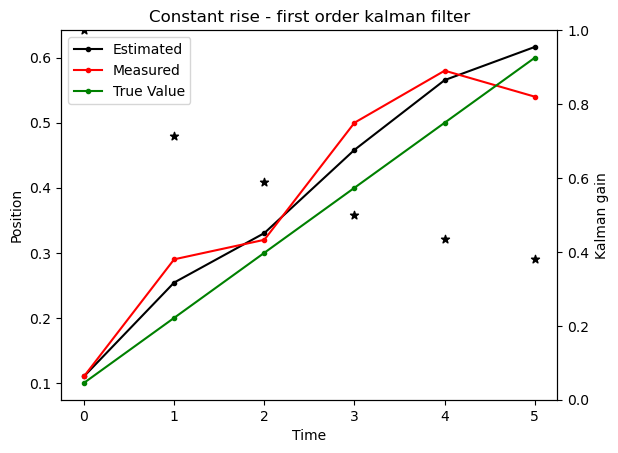

In [14]:
plt.plot(df_rising_first.index, np.stack((df_rising_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_rising_first.index, measure_list_2 ,marker=".",color="red")
plt.plot(df_rising_first.index, rising_zero_gt ,marker=".",color="g")
plt.title("Constant rise - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_rising_first.index, np.stack((df_rising_first['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

When P is initialised high - the measurements are used rather then the proposed initial values

#### Parabolic process with first order filter

$x_t = \frac{1}{2}at^2+v_0t+x_0$ <br>

In [15]:
def f_parabolic_step(X_prev):
    delta_t = 1
    acc = -10
    x_prev, v_prev = X_prev
    
    v_curr = v_prev + acc*delta_t
    x_curr = x_prev + v_curr*delta_t + 0.5*acc*delta_t**2
    
    return np.array([x_curr,v_curr])

Using a sampling rate of $\Delta t= 1$

In [16]:
delta_t = 1

Generate data set

In [17]:
samples = 61
para_steps = np.arange(samples+1)
para_gt = np.zeros(para_steps.shape[0])
para_prev = np.array([para_gt[0],50*5])

for step in para_steps[1:]:
    para_curr = f_parabolic_step(para_prev)
    if para_curr[0] < 0:
        para_curr[0] = -para_curr[0]
        para_curr[1] = -para_curr[1]*0.8
    
    para_gt[step] = para_curr[0]
    para_prev = np.copy(para_curr)
    
# Add noise
para_measure = para_gt+500*(np.random.rand(para_gt.shape[0])-0.5)

Set up tracker

In [18]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4, (delta_t**3)/2],
                [(delta_t**3)/2,   (delta_t**2)]])
H = np.array([1, 0])

In [19]:
firstFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_para_first = run_filter(firstFilter_para,para_measure, timing = True)

Frequency:  19942.461095852952 Per second


In [20]:
df_para_first

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0]","[[2000.000025, 1000.00005], [1000.00005, 1000....","[0.9998500224985, 0.4999250299964377]","[48.98672289684714, 24.493362366924615]","[[0.2999550067495006, 0.1499775089989066], [0...."
1,"[73.48008526377176, 24.493362366924615]","[[0.7499125412450955, 0.3000050254966883], [0....","[0.7142619140026379, 0.2857428725833783]","[251.55333162568166, 95.73216139592034]","[[0.21427857420079144, 0.08572286177501351], [..."
2,"[347.285493021602, 95.73216139592034]","[[0.42863216006613214, 0.12865572409032716], [...","[0.5882696147082345, 0.176571569499005]","[399.54224773656034, 111.41724348454919]","[[0.1764808844124703, 0.05297147084970148], [0..."
3,"[510.95949122110954, 111.41724348454919]","[[0.30014617657390025, 0.07071882131172848], [...","[0.5001217841416026, 0.11783599408305215]","[647.9208267830973, 143.68733376783862]","[[0.15003653524248078, 0.035350798224915644], ..."
4,"[791.6081605509358, 143.68733376783862]","[[0.22965963948827678, 0.04429730602088033], [...","[0.43359852699019924, 0.08363353126864177]","[822.9657001688274, 149.73565175532082]","[[0.1300795580970598, 0.025090059380592535], [..."
...,...,...,...,...,...
57,"[335.6107772541411, -73.33412741629913]","[[0.05229048234385976, 0.00420387653647337], [...","[0.14843001717208087, 0.011932983566584399]","[494.0594216141244, -60.595699534132834]","[[0.04452900515162426, 0.0035798950699753194],..."
58,"[433.46372207999156, -60.595699534132834]","[[0.05228753484134657, 0.004203634619747001], ...","[0.14842289229703906, 0.011932396704413957]","[552.3618330141317, -51.03693534947962]","[[0.04452686768911171, 0.0035797190113241867],..."
59,"[501.32489766465204, -51.03693534947962]","[[0.05228504688889975, 0.00420346018846385], [...","[0.14841687818043808, 0.011931985832454297]","[673.1941198102306, -37.219496599805936]","[[0.044525063454131424, 0.003579595749736289],..."
60,"[635.9746232104247, -37.219496599805936]","[[0.05228300156853098, 0.00420334236466327], [...","[0.14841193397280672, 0.011931720650579212]","[784.0835033174993, -25.312140257211937]","[[0.044523580191842015, 0.0035795161951737635]..."


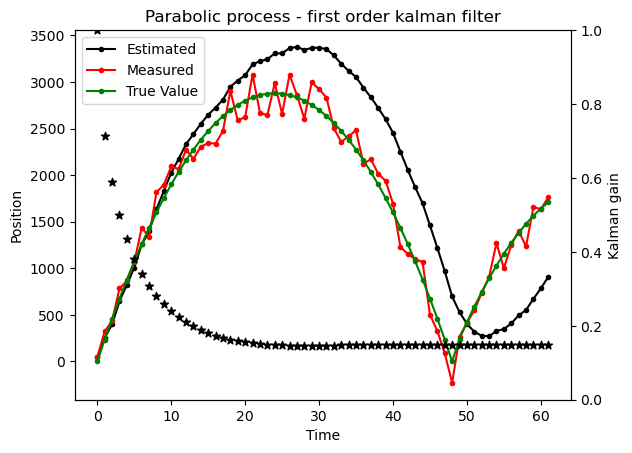

In [21]:
plt.plot(df_para_first.index, np.stack((df_para_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(para_steps, para_measure ,marker=".",color="red")
plt.plot(para_steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_para_first.index, np.stack((df_para_first['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

The first order kalman filter shows some overshoot as well as a general lag in responce. The lag can once again be addressed by increasing the sampling rate so that the velocity of each step is almost constant. Adding velocity correction measurements could also help

#### Parabolic process with second order filter (aka constant acceleration model)

In [22]:
delta_t = 1

In [23]:
X0 = np.array([0,0,0])  # position, velocity, acceleration
P0 = np.array([[1000,    0,   0],
               [0   , 1000,   0],
               [0   ,    0,1000]])  # Assume no correlation between states
F = np.array([[1, delta_t, 0.5*delta_t**2], 
              [0,       1,        delta_t],
              [0,       0,              1]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
H = np.array([1, 0, 0])

In [24]:
secondFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_para_second = run_filter(secondFilter_para, para_measure)
df_para_second

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0, 0.0]","[[2250.000025, 1500.00005, 500.00005], [1500.0...","[0.9998666844435554, 0.6665778044418766, 0.222...","[48.98753923336461, 32.658360214651054, 10.886...","[[0.2999600053331935, 0.19997334133264758, 0.0..."
1,"[87.08895984666148, 43.54448101194272, 10.8861...","[[1.1998650613274409, 0.7999433919937015, 0.26...","[0.799982006558318, 0.5333435737783767, 0.1778...","[275.64630072501797, 169.25461601718433, 52.79...","[[0.23999460196749547, 0.16000307213351306, 0...."
2,"[471.2982861532111, 222.04935483920195, 52.794...","[[0.8067367415568708, 0.44011095975681686, 0.1...","[0.728932826809397, 0.39766544583827873, 0.108...","[445.6533410248414, 208.05889074855403, 48.977...","[[0.21867984804281906, 0.1192996337514836, 0.0..."
3,"[678.2009436070169, 257.03631441579716, 48.977...","[[0.5857229650968022, 0.26044484466972595, 0.0...","[0.6612936416668248, 0.2940477496157746, 0.065...","[748.7044452199294, 288.3860729543104, 55.9533...","[[0.19838809250004735, 0.08821432488473235, 0...."
4,"[1065.0671792362423, 344.3393950783153, 55.953...","[[0.4466517889173058, 0.1656229568814297, 0.03...","[0.5982062797505384, 0.221820880013686, 0.0412...","[944.7441331898975, 299.72240447925697, 47.662...","[[0.17946188392516152, 0.0665462640041058, 0.0..."
...,...,...,...,...,...
57,"[1143.3016321199357, 180.1589532013087, 30.392...","[[0.1324078073159749, 0.024203845892708086, 0....","[0.3062104917528006, 0.05597458113197647, 0.00...","[1222.8570951374463, 194.70151081804937, 32.16...","[[0.09186314752584016, 0.01679237433959294, 0...."
58,"[1433.640785659727, 226.86587022651196, 32.164...","[[0.1324080313975922, 0.024204089861934515, 0....","[0.3062108512869992, 0.05597511633561506, 0.00...","[1372.6740735528224, 215.72120050484548, 30.80...","[[0.09186325538609977, 0.01679253490068452, 0...."
59,"[1603.798442253359, 246.52753689622796, 30.806...","[[0.13240856945318963, 0.02420436509903595, 0....","[0.30621171458426316, 0.055975683205455526, 0....","[1620.806404321549, 249.6366024588958, 31.1851...","[[0.09186351437527895, 0.016792704961636654, 0..."
60,"[1886.0356017432998, 280.82179238460566, 31.18...","[[0.13240926002115327, 0.024204630518108262, 0...","[0.30621282258080196, 0.05597620762544306, 0.0...","[1808.8384439215863, 266.71002496120826, 29.46...","[[0.09186384677424059, 0.016792862287632913, 0..."


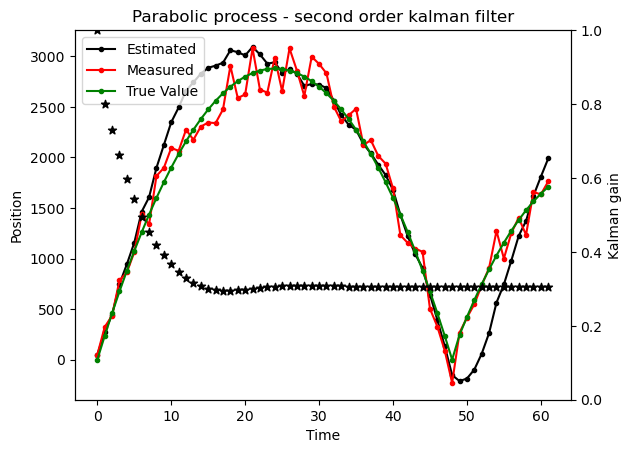

In [25]:
plt.plot(df_para_second.index, np.stack((df_para_second['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_para_second.index, para_measure ,marker=".",color="red")
plt.plot(df_para_second.index, para_gt ,marker=".",color="g")
plt.title("Parabolic process - second order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_para_second.index, np.stack((df_para_second['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

Second order filter tracks better and si more responcive but suppers higher sensitivity to noise from the displacement measurement that gets wrongly idenfitied as changes in acceleration

#### Parabolic process with first order filter and control input

We do however known the gravitational constant. Another approach is is to consider it as a control input

In [26]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4, (delta_t**3)/2],
                [(delta_t**3)/2,   (delta_t**2)]])
H = np.array([1, 0])
B_ = np.array([[0, 0],[0, delta_t]])
u_ = np.array([0, -10])

In [27]:
contFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H, B=B_,u=u_)
df_para_cont = run_filter(contFilter_para,para_measure)
df_para_cont

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, -10]","[[2000.000025, 1000.00005], [1000.00005, 1000....","[0.9998500224985, 0.4999250299964377]","[48.98672289684714, 14.493362366924615]","[[0.2999550067495006, 0.1499775089989066], [0...."
1,"[63.480085263771755, 4.4933623669246145]","[[0.7499125412450955, 0.3000050254966883], [0....","[0.7142619140026379, 0.2857428725833783]","[248.69595076570806, 78.58959012175413]","[[0.21427857420079144, 0.08572286177501351], [..."
2,"[327.28554088746216, 68.58959012175413]","[[0.42863216006613214, 0.12865572409032716], [...","[0.5882696147082345, 0.176571569499005]","[391.3076597385541, 87.80609514861303]","[[0.1764808844124703, 0.05297147084970148], [0..."
3,"[479.11375488716715, 77.80609514861303]","[[0.30014617657390025, 0.07071882131172848], [...","[0.5001217841416026, 0.11783599408305215]","[632.0018369217892, 113.82875943011933]","[[0.15003653524248078, 0.035350798224915644], ..."
4,"[745.8305963519085, 103.82875943011933]","[[0.22965963948827678, 0.04429730602088033], [...","[0.43359852699019924, 0.08363353126864177]","[797.0372203756976, 113.70561676444314]","[[0.1300795580970598, 0.025090059380592535], [..."
...,...,...,...,...,...
57,"[-518.844308765169, -207.87161596930363]","[[0.05229048234385976, 0.00420387653647337], [...","[0.14843001717208087, 0.011932983566584399]","[-233.56888131456765, -184.93698958728444]","[[0.04452900515162426, 0.0035798950699753194],..."
58,"[-418.50587090185206, -194.93698958728444]","[[0.05228753484134657, 0.004203634619747001], ...","[0.14842289229703906, 0.011932396704413957]","[-173.15596882821552, -175.2121862390738]","[[0.04452686768911171, 0.0035797190113241867],..."
59,"[-348.3681550672893, -185.2121862390738]","[[0.05228504688889975, 0.00420346018846385], [...","[0.14841687818043808, 0.011931985832454297]","[-50.390142623629686, -161.25622202226774]","[[0.044525063454131424, 0.003579595749736289],..."
60,"[-211.64636464589742, -171.25622202226774]","[[0.05228300156853098, 0.00420334236466327], [...","[0.14841193397280672, 0.011931720650579212]","[62.25958554487485, -149.2352888350041]","[[0.044523580191842015, 0.0035795161951737635]..."


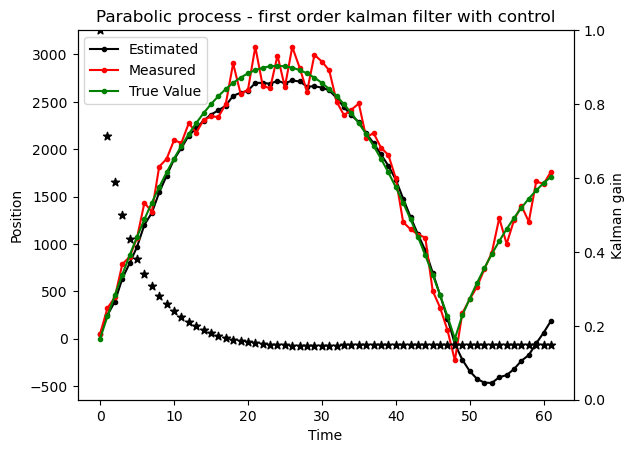

In [28]:
plt.plot(df_para_cont.index, np.stack((df_para_cont['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(para_steps, para_measure ,marker=".",color="red")
plt.plot(para_steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - first order kalman filter with control")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_para_cont.index, np.stack((df_para_cont['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

This is the best result seen yet when tracking the parabola, however it suffers greater lag on the rebound. If initialised with prior knowledge it can be a good tracker

####  Constant process with first order filter and control

Instantiate filter

In [29]:
measure_list_3 = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15, 0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]

In [30]:
contFilter_const = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H, B=B_,u=u_)
df_const_cont = run_filter(contFilter_const,measure_list_3)
df_const_cont

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, -10]","[[2000.000025, 1000.00005], [1000.00005, 1000....","[0.9998500224985, 0.4999250299964377]","[0.89986502024865, -9.550067473003207]","[[0.2999550067495006, 0.1499775089989066], [0...."
1,"[-8.650202452754556, -19.550067473003207]","[[0.7499125412450955, 0.3000050254966883], [0....","[0.7142619140026379, 0.2857428725833783]","[-1.900282761137663, -16.84973947765863]","[[0.21427857420079144, 0.08572286177501351], [..."
2,"[-18.750022238796294, -26.84973947765863]","[[0.42863216006613214, 0.12865572409032716], [...","[0.5882696147082345, 0.176571569499005]","[-7.0728573044297125, -23.344789896364215]","[[0.1764808844124703, 0.05297147084970148], [0..."
3,"[-30.41764720079393, -33.34478989636422]","[[0.30014617657390025, 0.07071882131172848], [...","[0.5001217841416026, 0.11783599408305215]","[-14.704997429201443, -29.642660206708044]","[[0.15003653524248078, 0.035350798224915644], ..."
4,"[-44.347657635909485, -39.642660206708044]","[[0.22965963948827678, 0.04429730602088033], [...","[0.43359852699019924, 0.08363353126864177]","[-24.70666000887278, -35.85425714041898]","[[0.1300795580970598, 0.025090059380592535], [..."
5,"[-60.56091714929176, -45.85425714041898]","[[0.1853803121258234, 0.030235694648171087], [...","[0.3819279593643014, 0.06229279163744325]","[-37.02998528789972, -42.01634111584637]","[[0.1145783878092904, 0.018687837491232973], [..."
6,"[-79.0463264037461, -52.01634111584637]","[[0.15519033968398743, 0.021949114383464054], ...","[0.3409350466262689, 0.048219640159108096]","[-51.687541369698124, -48.1468921325674]","[[0.10228051398788068, 0.014465892047732428], ..."
7,"[-99.83443350226553, -58.1468921325674]","[[0.13341964463393133, 0.01669823859831822], [...","[0.3078301740259565, 0.03852672301556992]","[-68.82533530685699, -54.26592451489527]","[[0.09234905220778697, 0.011558016904670976], ..."
8,"[-123.09125982175226, -64.26592451489526]","[[0.11706985743186035, 0.013187788319402401], ...","[0.2806960401135843, 0.03162009453429989]","[-88.30143898309751, -60.346890162631226]","[[0.08420881203407528, 0.009486028360289967], ..."
9,"[-148.64832914572872, -70.34689016263123]","[[0.10441413498497554, 0.010744294590610286], ...","[0.2581861659925775, 0.026567554546552755]","[-109.97247287149884, -66.36711488206961]","[[0.07745584979777326, 0.007970266363965826], ..."


Check results

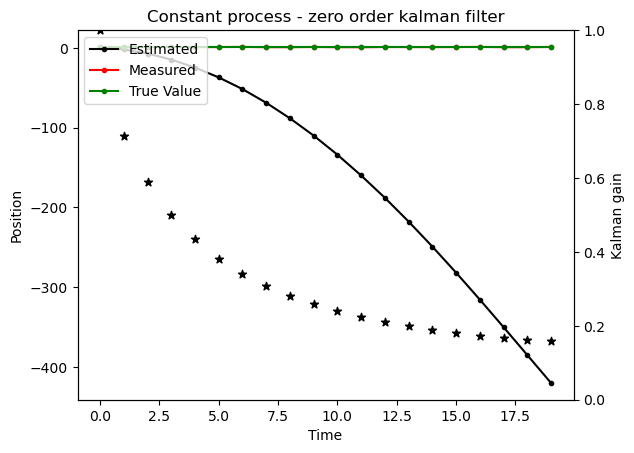

In [31]:
plt.plot(df_const_cont.index, np.stack((df_const_cont['xt_curr'].to_numpy()).tolist(), axis=0)[:,0] ,marker=".",color="black")
plt.plot(df_const_cont.index, measure_list_3 ,marker=".",color="red")
plt.plot(df_const_cont.index, np.ones(len(df_const_cont.index)) ,marker=".",color="g")
plt.title("Constant process - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_const_cont.index, np.stack((df_const_cont['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

This model does however add error in other circumstances

#### Ball rolling with drag (non-linear) using first order filter

Create physics equation

In [32]:
def f_nonlinear_step(X_prev, u_curr=np.zeros(1)):
    delta_t = 1
    x_prev, v_prev, lambda_prev = X_prev
    
    lambda_curr = lambda_prev  
    v_curr = v_prev*lambda_curr  # Non linear combination of arguments
    x_curr = x_prev + v_curr*delta_t
    
    return np.array([x_curr,v_curr,lambda_prev])

Generate data set

In [33]:
delta_t = 1

In [34]:
samples = 40
drag_steps = np.arange(samples+1)
drag_gt = np.zeros(drag_steps.shape[0])
drag_prev = np.array([drag_gt[0],2,0.9])

for step in drag_steps[1:]:
    drag_curr = f_nonlinear_step(drag_prev)
    drag_gt[step] = drag_curr[0]
    drag_prev = np.copy(drag_curr)

# Add noise
drag_measure = drag_gt+4*(np.random.rand(drag_gt.shape[0])-0.5)

Create first order filter

In [35]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4, (delta_t**3)/2],
                [(delta_t**3)/2,   (delta_t**2)]])
H = np.array([1, 0])

In [36]:
firstFilter_drag = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_drag_first = run_filter(firstFilter_drag, drag_measure)
#df_drag_first

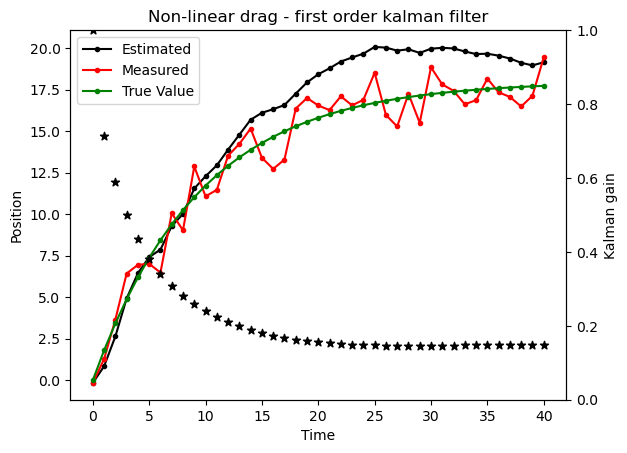

In [37]:
plt.plot(df_drag_first.index, np.stack((df_drag_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(drag_steps, drag_measure ,marker=".",color="red")
plt.plot(drag_steps, drag_gt ,marker=".",color="g")
plt.title("Non-linear drag - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_drag_first.index, np.stack((df_drag_first['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

The standard Kalman filter however shoes lag in this case as it does not adapt well to the non-linear changes in velocity. As always, increasing the mangitude of process noise can help the estimates converge closer by weighing the measurements higher.

## More theory

#### Extended Kalman filter

For a nonlinear dynamic system - one is not able to define either or both the process model or measurement model with multiplication of vectors and matrices. A nonlinear difference equation is where the recursion function f depends
on nonlinear combinations of its arguments (f may involve quadratics, exponentials, reciprocals, or powers of the x„'s, and so forth). In an EKF the models are linearized about a current estimate. The slope (first derviative) of a function gives a good linear approximation of the function in the local region (as per the first order of taylor series expansion)

The Jacobian matrix is a matrix containing the first-order partial derivatives of a function. Jacobian is the best linear approximation of the true gradient at a specific point.  Unless a linear function with and constant slope, the Jacobian will differ from point to point. 

A nonlinear process model: <br>
$x_t=f(x_{t−1},u_{t})+w_{t}$ <br>
$z_t=h(x_{t})+{\upsilon}_t$

Can be linearlized at a point using the first order taylor series expansion:<br>
$f(x_{k−1},u_{t}) \approx f(\mu_{t−1},u_{t}) + F_t(x_{t-1}-\mu_{t-1})$ <br>
$h(x_t) \approx h(\mu_{t}) + H_t(x_t-\mu_t)$ <br>
Where $\mu$ is the mean state which is the point where the linearization occurs

The following jacobians are computed and updated each cycle to be used in the standard update equations: <br>
$F_t = \frac{\partial f(\mu_{t-1}, u_{t})}{\partial x_{t-1}}$ <br>
$H_t = \frac{\partial h(\mu_{t})}{\partial x_t}$ <br>
The prediction step for $x_{t|t-1}$ and the predicted measurement in the innovation term are still computed using the true functions.

#### Ball rolling with drag (non-linear) using EKF

In [38]:
delta_t = 1

Motion and observation jacobians are defined which can be updated at each cycle

In [39]:
X0 = np.array([0,0,1])  # position, velocity, lambda
P0 = np.array([[1000,    0,    0],
               [0   , 1000,    0],
               [0   ,    0, 1000]])  # Assume no correlation between states
F =  lambda x_prev: np.array([[1,   delta_t,         0], 
                              [0, x_prev[2], x_prev[1]],
                              [0,         0,         1]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
Q = q*np.array([[(delta_t**2)/2,(delta_t**2)/2,(delta_t**2)/2],
                [(delta_t**2)/2,             1,             1],
                [(delta_t**2)/2,             1,             1]])  # Noise model propegates thorough lambda
H = lambda H_prev: np.array([1, 0, 0])
h = lambda y: y[0]

In [40]:
EKFFilter_drag = MyKalmanFilterEKF(X0, P0, r, Q, F, H, f_nonlinear_step, h)
df_drag_EKF = run_filter(EKFFilter_drag, drag_measure)

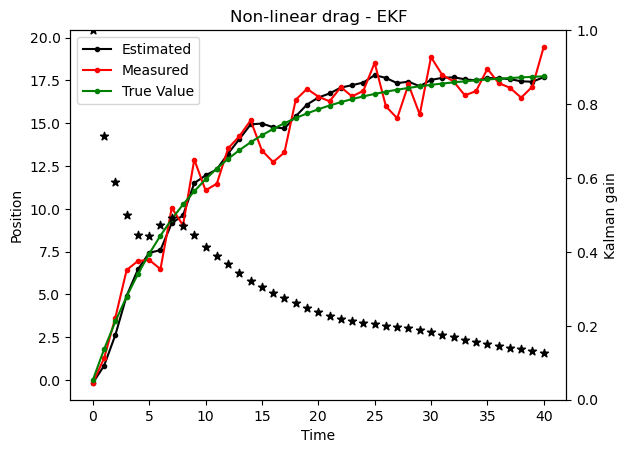

In [41]:
plt.plot(df_drag_EKF.index, np.stack((df_drag_EKF['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_drag_EKF.index, drag_measure ,marker=".",color="red")
plt.plot(df_drag_EKF.index, drag_gt ,marker=".",color="g")
plt.title("Non-linear drag - EKF")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.twinx()
plt.scatter(df_drag_EKF.index, np.stack((df_drag_EKF['k_gain'].to_numpy()).tolist())[:,0], marker="*",color="black")
plt.ylabel("Kalman gain")
plt.ylim([0,1])
plt.show()

The EKF is significantly better able to track the non-linear shape - however, due to the additional state, it is more sensitive to noise

## Bonus: Sensor fusion

There are various approaches that can be taken to fuse sensors. Some are:
- Merge with observation matrix
- Pre-combine with minimum meansquare estimates (equivalent to previous)
- Correction step performed per each sensor arrival -> Useful when at different sampling rates

Kalman filters also have an advantage of allowing predictive steps inbetween process measurements when decision making which occurs faster than the sample rate occurs

#### Merge with observation matrix

Suppose you have two measurements for the state: <br>
$z = [x_A,x_B]^T $

The matrix H converts x to z measurements: <br>
$z_t=Hx_{t}$

## Neual kalman filtering

In neural kalman filtering the idea is to learn the gain. 